In [1]:
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
import h5py
from matplotlib import gridspec
from data_analysis_codes.tools import ReadingTools as RRead
from data_analysis_codes.tools import Cstyle
plt.style.use(Cstyle.style1)
from data_analysis_codes import param
from data_analysis_codes.tools import LinData

In [2]:
def nonlincalc(var):
    return var[-1]

def geterror(path, filetype, var):    
    try:
        ferr = pd.read_table(path+'/'+filetype+'_data_error.csv', delimiter=',')
        var_err = np.array(list(ferr[var+'_error']))
        return var_err, True
    except:
        return np.zeros(len(a_lin)+2), False
    
def ferr(x, var_error):
    return np.array(list(x)[0::2])[:len(var_error)]
    
def nl(var, p, file='h5'):
    # -- Data
    path = '/home/robynm/simulations/'+p.sim_name
    if file=='h5':
        try:
            f = pd.read_table(path+'/h5_data.csv', delimiter=',')
            var_data = np.array(f[var])
        except:
            f = pd.read_table(path+'/asc_data.csv', delimiter=',')
            var_data = np.array(f[var])
            file='asc'
    else:
        f = pd.read_table(path+'/asc_data.csv', delimiter=',')
        var_data = np.array(f[var])
    Lin = LinData.LinData_Class(p)
    a_lin = Lin.a(file)[:len(var_data)]
    
    var_error, have_error = geterror(path, file, var)
    var_errortop = ferr(var_data, var_error)+var_error
    var_errordow = ferr(var_data, var_error)-var_error
    
    proper_var_name = re.split('_', var)[0]
    try:
        loc = re.split('_', var)[1]
    except:
        loc = ''
    
    if proper_var_name not in ['RicciS', 'RicciSconf', 'Ca', 'Da', 'Za']:
        var_0th = getattr(Lin, proper_var_name)(file)[:len(var_data)]
        var_data = var_data/var_0th-1
        if have_error:
            var_errortop = var_errortop/ferr(var_0th, var_error)-1
            var_errordow = var_errordow/ferr(var_0th, var_error)-1
    if loc not in ['av', 'cent']:
        var_1st = getattr(Lin, 'd'+proper_var_name)(file, loc)[:len(var_data)]
        var_data = var_data/var_1st-1
        if have_error:
            var_errortop = var_errortop/ferr(var_1st, var_error)-1
            var_errordow = var_errordow/ferr(var_1st, var_error)-1
        
    if have_error:
        et = nonlincalc(var_errortop)
        v = nonlincalc(var_data)
        ed = nonlincalc(var_errordow)
        if v<0:
            v = abs(v)
            etn = abs(ed)
            edn = abs(et)
        else:
            etn = et
            edn = ed
        return etn, v, edn
    else:
        return 0, nonlincalc(var_data), 0

In [3]:
A1e2 = param.pflrw_A1e2_L6_z200_N64()
A1e3 = param.pflrw_A1e3_L6_z200_N64()
A1e4 = param.pflrw_A1e4_L6_z200_N64()
A1e5 = param.pflrw_A1e5_L6_z200_N64()
A1e6 = param.pflrw_A1e6_L6_z200_N64()
A1e7 = param.pflrw_A1e7_L6_z200_N64()
pA = [A1e2, A1e3, A1e4, A1e5, A1e6, A1e7]
As = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]

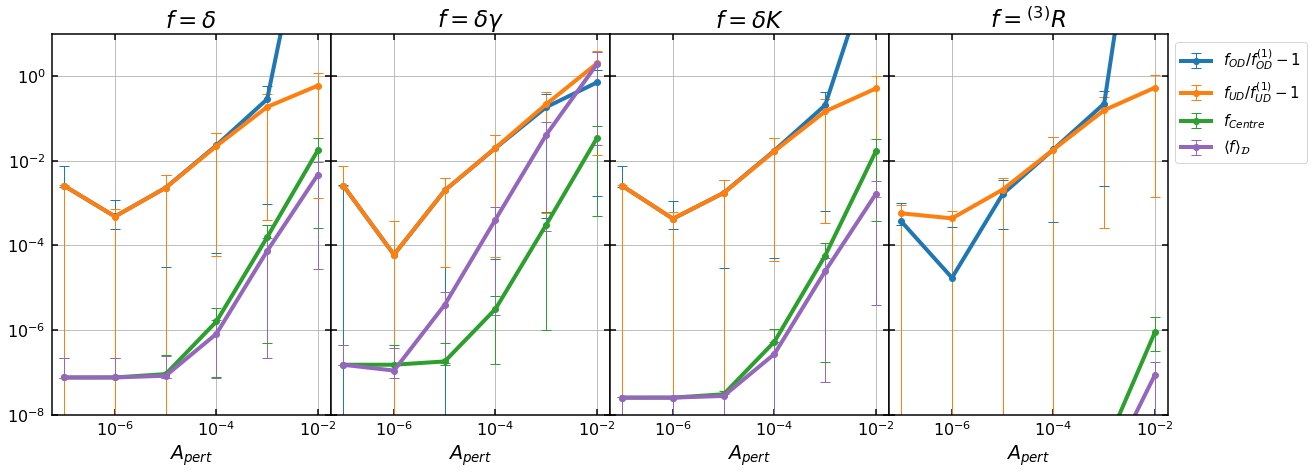

In [5]:
zevars = ['rho']#, 'gdet', 'K', 'RicciS', 'Da', 'Za', 'Ca']
locs = ['OD', 'UD', 'cent', 'av']
lcol = ['C0', 'C1', 'C2', 'C4']
leg = [r'$f_{OD}/f_{OD}^{(1)}-1$', r'$f_{UD}/f_{UD}^{(1)}-1$',
       r'$f_{Centre}$', r'$\langle f\rangle_{\mathcal{D}}$']

def plotstuff(var, leg):
    ET = np.zeros((len(pA), 4))
    ED = np.zeros((len(pA), 4))
    ntot = np.zeros((len(pA), 4))
    for pi, p in enumerate(pA):
        for loci, loc in enumerate(locs):
            et, v, ed = nl(var+'_'+loc, p)
            #print(var+loc, et, v, ed)
            ET[pi, loci] = et
            ntot[pi, loci] = v
            ED[pi, loci] = ed
    for loci, loc in enumerate(locs):
        err = np.array([ED[:,loci], ET[:,loci]])
        plt.errorbar(As, ntot[:,loci], yerr=err, color=lcol[loci], elinewidth=1, capsize=5, linewidth=4, marker='o', label=leg[loci])
    plt.grid()

ymin = 1e-8
ymax = 1e1
    
plt.figure(figsize=(20, 7))
plt.subplot(141, xscale="log", yscale="log")
plotstuff('rho', leg)
plt.xlabel(r'$A_{pert}$')
plt.ylim(ymin, ymax)
plt.title(r'$f=\delta$')

plt.subplot(142, xscale="log", yscale="log")
plotstuff('gdet', leg)
plt.xlabel(r'$A_{pert}$')
plt.ylim(ymin, ymax)
plt.gca().set_yticklabels([])
plt.title(r'$f=\delta\gamma$')

plt.subplot(143, xscale="log", yscale="log")
plotstuff('K', leg)
plt.xlabel(r'$A_{pert}$')
plt.ylim(ymin, ymax)
plt.gca().set_yticklabels([])
plt.title(r'$f=\delta K$')

plt.subplot(144, xscale="log", yscale="log")
plotstuff('RicciS', leg)
plt.xlabel(r'$A_{pert}$')
plt.ylim(ymin, ymax)
plt.gca().set_yticklabels([])
plt.title(r'$f=^{(3)}R$')
plt.legend(bbox_to_anchor=(1,1), fontsize=15)

plt.subplots_adjust(wspace=0)

path = '/home/robynm/ET/pflrwcodes/Plots/'
plt.savefig(path+'NonLin')